# Deep Q_Learning
Este notebook documenta un experimento de aprendizaje por refuerzo basado en el algoritmo Deep Q-Learning (DQN). En este método, el agente utiliza una red neuronal profunda para aproximar la función Q y se aprovechan técnicas como el replay buffer y la target network para estabilizar el entrenamiento. El objetivo es entrenar un agente en el entorno 'CartPole-v1' de Gymnasium, donde debe aprender a mantener el equilibrio del poste durante el mayor tiempo posible. El notebook describe en detalle la arquitectura del agente, la implementación de la política epsilon-greedy, el manejo del buffer de experiencia, el proceso de actualización de la red neuronal y el análisis comparativo de los resultados en la fase de evaluación.

## Preparación del entorno
La preparación consta de las siguientes partes:

* **Instalación del Github**: Para hacer uso de clases y herencia, instalamos el repostiroio de github, donde tenemos implementrado todo el código.

* **Instalación de Dependencias**: Se instalan las librerías necesarias para utilizar el entorno gymnasium para la simulación, con el objetivo de crear un ambiente controlado para que el agente pueda interactuar.

* **Importación de Librerías**: Se importan las bibliotecas necesarias como numpy para el manejo de matrices y matplotlib para la visualización de los resultados.

* **Implantación de semilla**: Para poder replicar los resultados, implantamos una semilla para todos los procesos random implicados.

* **Importación del Entorno CartPole**: Se carga el entorno CartPole.

In [1]:
!git clone https://github.com/Imartinezcuevas/RL_MC_OL.git

Clonando en 'RL_MC_OL'...
remote: Enumerating objects: 318, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 318 (delta 18), reused 21 (delta 2), pack-reused 275 (from 1)
Recibiendo objetos: 100% (318/318), 2.27 MiB | 6.52 MiB/s, listo.
Resolviendo deltas: 100% (167/167), listo.


In [ ]:
import sys

sys.path.append('/content/RL_MC_OL/src')
print(sys.path)

import numpy as np
from tqdm import tqdm
import gymnasium as gym
import random
import torch
import gc
import os

from agentes import DeepQAgent
from politicas import EpsilonGreedyPolicy
from plotting import plot_training_comparation

['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/antonio/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', 'src']


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Liberación de memoria para evitar problemas de consumo en GPU
gc.collect() # Ejecuta el recolector de basura de Python
torch.cuda.empty_cache() # Vacía la caché de memoria en GPU

# Depuración de errores en CUDA
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # Muestra errores de CUDA en el punto exacto donde ocurren

seed_value= 100
random.seed(seed_value)
np.random.seed(seed_value)
np.random.default_rng(seed_value) # Establece una instancia del generador de NumPy con la misma semilla

os.environ['PYTHONHASHSEED'] = str(seed_value)
torch.manual_seed(seed_value) 

if torch.cuda.is_available(): # Si hay GPU disponible
    torch.cuda.manual_seed(seed_value) # Fija la semilla para la GPU
    torch.backends.cudnn.deterministic = True # Hace las operaciones de CUDNN determinísticas
    torch.backends.cudnn.benchmark = False # Desactiva optimizaciones de CUDNN para evitar variabilidad

Usando dispositivo: cpu


In [3]:
name = 'CartPole-v1'
env = gym.make(name)
env.reset(seed=seed_value)

(array([ 0.03349816,  0.0096554 , -0.02111368, -0.04570484], dtype=float32),
 {})

## Componentes Clave

Deep Q-Learning (DQN) es un algoritmo de aprendizaje por refuerzo off-policy que utiliza redes neuronales profundas para aproximar la función Q. Este método permite manejar entornos con espacios de estado complejos y continuos, y se beneficia de técnicas como el replay buffer y la target network, las cuales ayudan a estabilizar y mejorar el proceso de aprendizaje al reutilizar experiencias pasadas y reducir la correlación entre muestras.

1.  Agente (`Agent`, `DeepQAgent`):
    *   La clase `Agent` define la estructura base de un agente de RL.
    *   `DeepQAgent` implementa el algoritmo DQN, utilizando una red neuronal para aproximar la función Q. Además, incorpora un replay buffer para almacenar transiciones y una target network que se actualiza periódicamente, lo que contribuye a la estabilidad del entrenamiento.     

2. Política (Policy, EpsilonGreedyPolicy):
    * La clase `Policy` define la estructura general de una política.
    * `EpsilonGreedyPolicy` se utiliza para balancear la exploración y la explotación. Mediante esta política, el agente tiende a seleccionar la acción con el mayor valor Q, pero con cierta probabilidad elige una acción aleatoria para explorar el espacio de soluciones

3. Entorno (`gym.Env`):
    * El entorno de Gymnasium donde el agente interactua.
    * En este experimento se utiliza el entorno CartPole-v1, un escenario clásico en el que el agente debe aprender a mantener el equilibrio de un poste montado sobre un carro en movimiento, maximizando el tiempo en el que el poste se mantiene vertical.

## Función de entrenamiento
Se ha adaptado el bucle de entrenamiento de referencia para emplear el algoritmo Deep Q-Learning. En este enfoque, la función `train_agent` simula múltiples episodios de interacción entre el agente y el entorno, actualizando el agente en cada transición a través del almacenamiento en un replay buffer y la actualización en mini-batch de la red Q principal. La target network se sincroniza de forma periódica para estabilizar el proceso de aprendizaje. Además, se evalúa el rendimiento del agente de manera regular para analizar la mejora en la aproximación de la función Q.

In [4]:
def train_agent(agent, env, episodes=500, max_steps=500):
    """
    Función de entrenamiento basada en episodios.
    Actualiza la barra de progreso con estadísticas resumidas en lugar de imprimir en cada episodio.
    """
    episode_rewards = []
    episode_lengths = []
    
    progress_bar = tqdm(range(episodes), desc="Entrenando episodios", unit="ep")
    
    for ep in progress_bar:
        state, _ = env.reset()
        agent.start_episode()
        total_reward = 0
        
        for step in range(max_steps):
            action = agent.get_action(state)
            next_state, reward, done, truncated, info = env.step(action)
            agent.update(state, action, next_state, reward, done, info)
            total_reward += reward
            state = next_state
            if done or truncated:
                break
        
        agent.end_episode(total_reward, step + 1)
        episode_rewards.append(total_reward)
        episode_lengths.append(step + 1)
        
        if hasattr(agent.policy, 'decay_epsilon'):
            agent.policy.decay_epsilon()
        
        # Actualiza el progress bar con estadísticas resumidas
        progress_bar.set_postfix({
            "Recompensa": f"{total_reward:.1f}",
            "Pasos": step + 1,
            "Epsilon": f"{agent.policy.epsilon:.4f}"
        })
        
    return episode_rewards, episode_lengths

## Función de evaluación
La función `evaluate_agent` evalúa el rendimiento del agente DQN ejecutando múltiples episodios en modo determinista, fijando epsilon a 0 para que se seleccione siempre la acción con el mayor valor Q. Se calculan métricas como la tasa de éxito, la duración promedio de los episodios y la recompensa promedio. De esta forma, se obtiene una medida clara de la eficacia de la red Q en entornos complejos como CartPole-v1, aprovechando las técnicas de replay buffer y target network para estabilizar el aprendizaje.

In [ ]:
def evaluate_agent(agent, env, episodes=10, max_steps=500):
    """
    Función de evaluación: ejecuta el agente sin actualizarlo y muestra la recompensa de cada episodio.
    """
    total_rewards = []
    for ep in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        for step in range(max_steps):
            # Se utiliza la política de selección (por lo general greedy)
            action = agent.policy.select_action(state, agent.get_action_values(state))
            next_state, reward, done, truncated, info = env.step(action)
            total_reward += reward
            state = next_state
            if done or truncated:
                break
        total_rewards.append(total_reward)
        print(f"Episodio de evaluación {ep+1}/{episodes} - Recompensa: {total_reward}")
    avg_reward = np.mean(total_rewards)
    print(f"Recompensa media en evaluación: {avg_reward:.1f}")
    return total_rewards

## Realizamos el entrenamiento

Entrenando episodios: 100%|██████████| 500/500 [01:45<00:00,  4.74ep/s, Recompensa=500.0, Pasos=500, Epsilon=0.0816]


Episodio de evaluación 1/10 - Recompensa: 500.0
Episodio de evaluación 2/10 - Recompensa: 500.0
Episodio de evaluación 3/10 - Recompensa: 500.0
Episodio de evaluación 4/10 - Recompensa: 500.0
Episodio de evaluación 5/10 - Recompensa: 500.0
Episodio de evaluación 6/10 - Recompensa: 500.0
Episodio de evaluación 7/10 - Recompensa: 500.0
Episodio de evaluación 8/10 - Recompensa: 500.0
Episodio de evaluación 9/10 - Recompensa: 500.0
Episodio de evaluación 10/10 - Recompensa: 500.0
Recompensa media en evaluación: 500.0


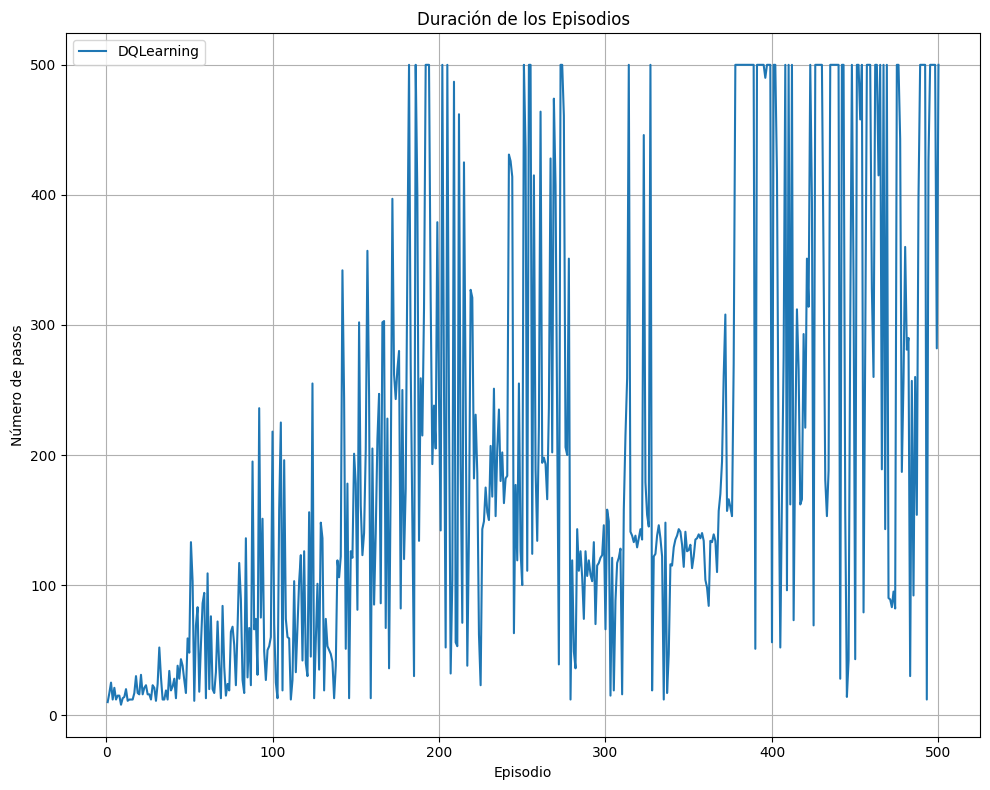

In [ ]:
policy = EpsilonGreedyPolicy(env.action_space, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01)
    
# Crear el agente Deep Q-Learning
agent = DeepQAgent(
        env, 
        policy=policy, 
        gamma=0.99, 
        lr=0.001, 
        batch_size=32, 
        replay_buffer_size=10000, 
        target_update_freq=100
)

episodes = 500
episode_rewards, episode_lengths = train_agent(agent, env, episodes=episodes, max_steps=500)
    
# Evaluación (por ejemplo, 10 episodios)
evaluate_agent(agent, env, episodes=10, max_steps=500)
    
algorithms_data = {
        "DQLearning": (episode_rewards, episode_lengths)
}
plot_training_comparation(algorithms_data, same=True)

## Resultados y conclusiones

1. Aprendizaje exitoso:
    * Hacia los últimos episodios del entrenamiento, el agente alcanza de manera recurrente los 500 pasos de duración (el máximo posible en la configuración utilizada).
    *   En la evaluación, todos los episodios registran 500 pasos de duración y 500 de recompensa, lo cual confirma que el agente ha aprendido una política que mantiene el poste en equilibrio durante todo el episodio.
2.  Evolución del rendimiento durante el entrenamiento:
    *   Al inicio, se observan episodios cortos (alrededor de 20-40 pasos). Esto es normal, ya que el agente está en fase de exploración y aún no ha aprendido a controlar el poste.
    *   A medida que avanza el entrenamiento, la duración de los episodios aumenta de forma más o menos gradual, aunque con altibajos notables. Estos picos y caídas reflejan la exploración, el uso del replay buffer y la actualización periódica de la target network.
    *   Finalmente, en la segunda mitad del entrenamiento, aparecen episodios de 500 pasos con mucha frecuencia, indicio de que la política estimada por la red neuronal se ha vuelto muy sólida.
3.  Estabilidad en evaluación::
    *   El agente mantiene sin problemas los 500 pasos en todos los episodios de prueba, demostrando un comportamiento estable y convergente.

El uso de DQN con la configuración de hiperparámetros dada, demuestra ser muy efectivo para CartPole-v1, alcanzando la duración máxima de 500 pasos en prácticamente todos los episodios al final del entrenamiento.